In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
from datetime import datetime
from zoneinfo import ZoneInfo

stock_symbol = 'TSLA'  # Example for Apple Inc.
start_date = '2024-01-01'  # Adjust based on your analysis period
end_date = datetime.now(ZoneInfo("UTC"))

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

Tweets over time.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load tweets from a JSONL file
def load_tweets(file_path):
    tweets = []
    with open(file_path, 'r') as file:
        for line in file:
            tweet = json.loads(line)
            tweets.append({'date': tweet['date'], 'tweet': 1})  # Assuming each line is a tweet
    return pd.DataFrame(tweets)

# Function to filter tweets, plot rolling average with adjustable granularity, start, and end dates
def plot_rolling_average(file_path, start_date, end_date, granularity='D', rolling_window=7):
    """
    Filter tweets by start and end date, then plot the rolling average of tweets over time.

    Parameters:
    - file_path: Path to the JSONL file containing tweet data.
    - start_date: Start date as a string in 'YYYY-MM-DD HH:MM' format.
    - end_date: End date as a string in 'YYYY-MM-DD HH:MM' format.
    - granularity: Resampling granularity ('T' for minute, 'H' for hour, 'D' for day, etc.).
    - rolling_window: The window size for calculating the rolling average, in terms of the number of periods.
    """
    df = load_tweets(file_path)
    df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime
    df.set_index('date', inplace=True)

    # Filter based on start and end date
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Resample and aggregate data based on the specified granularity
    resampled_df = filtered_df.resample(granularity).count()

    # Calculate the rolling average
    rolling_avg = resampled_df.rolling(window=rolling_window).mean()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_avg, label=f'{rolling_window}-Period Rolling Average')
    plt.title('Rolling Average of Tweets Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Tweets')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
file_path = 'english_tweets.jsonl'
start_date = '2024-02-04 06:00'
end_date = '2024-02-05 18:00'
plot_rolling_average(file_path, start_date, end_date, granularity='T', rolling_window=60)

1. Prepare data for reading.

In [19]:
import pandas as pd
import json
from datetime import datetime
from zoneinfo import ZoneInfo
from dateutil.parser import parse

def read_jsonl_files(file_paths):
    """
    Reads and combines JSONL files into a single DataFrame.
    """
    df_list = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            df_list.append(pd.DataFrame([json.loads(line) for line in file]))
    return pd.concat(df_list, ignore_index=True)

def preprocess_data(df, date_key='date'):
    """
    Converts date strings to datetime objects and categorizes sentiment and emotion columns.
    """
    df[date_key] = pd.to_datetime(df[date_key])  # Convert 'date' column to datetime
    try:
        df['sentiment'] = df['sentiment'].astype('category')  # Categorize 'sentiment' column
        df['emotion'] = df['emotion'].astype('category')  # Categorize 'emotion' column
    except Exception:
        pass
    df.set_index(date_key, inplace=True)  # Set 'date' as the index
    return df

def filter_by_date(df, start_date_str, end_date_str):
    """
    Filters DataFrame by a given start and end date.
    """
    # start_date = datetime.strptime(start_date_str, '%Y-%m-%d').replace(tzinfo=ZoneInfo("UTC"))
    start_date = parse(start_date_str)
    # end_date = datetime.now(ZoneInfo("UTC")) if end_date_str == "now" else datetime.strptime(end_date_str, '%Y-%m-%d').replace(tzinfo=ZoneInfo("UTC"))
    end_date = datetime.now(ZoneInfo("UTC")) if end_date_str == "now" else parse(end_date_str)
    return df[(df.index >= start_date) & (df.index <= end_date)]

def resample_sentiments(df, desired_order=None):
    """
    Resamples sentiment and emotion counts to hourly intervals and reorders columns if desired order is provided.
    """
    hourly_sentiments = df.groupby('sentiment').resample('30min').size().unstack(0, fill_value=0) # Group by sentiment and resample by hour
    hourly_emotions = df.groupby('emotion').resample('30min').size().unstack(0, fill_value=0) # Group by emotion and resample by hour

    if desired_order:
        hourly_sentiments = hourly_sentiments[desired_order]  # Reorder columns if desired order is provided

    return hourly_sentiments, hourly_emotions


In [51]:
df = read_jsonl_files(['backup/final_TSLA_stocktweets.jsonl', 'backup/final_TSLA_tweets.jsonl'])  # Read and combine JSONL files
df = preprocess_data(df)  # Convert dates and categorize sentiments/emotions
df = filter_by_date(df, '2024-02-20T00:00+00:00', "now")

# Resample sentiments and emotions to hourly intervals
desired_order=['strong positive', 'moderately positive', 'mildly positive', 'neutral', 'mildly negative', 'moderately negative', 'strong negative']
hourly_sentiments, hourly_emotions = resample_sentiments(df, desired_order)

# Calculate the derivative (rate of change) for sentiments and emotions
hourly_sentiments_derivative = hourly_sentiments.diff().fillna(0)
hourly_emotions_derivative = hourly_emotions.diff().fillna(0)

In [54]:
df = read_jsonl_files(['backup/TSLA_stocktweets.jsonl', 'backup/trash_TSLA_stocktweets.jsonl'])  # Read and combine JSONL files
df = preprocess_data(df, 'created_at')  # Convert dates and categorize sentiments/emotions
df = filter_by_date(df, '2024-02-20T00:00+00:00', "now")

Print specific tweets by date range/type

In [ ]:
sentiment = None  # Set to None if you don't want to filter by sentiment
emotion = 'anger'  # Set to your desired emotion or keep as None
filtered_df = filter_by_date(df, '2024-02-26T13:00:00Z', "2024-02-26T16:00:00Z")

# Additional filtering based on sentiment and/or emotion if specified
if sentiment:
    filtered_df = filtered_df[filtered_df['sentiment'] == sentiment]
if emotion:
    filtered_df = filtered_df[filtered_df['emotion'] == emotion]

# Display the filtered DataFrame as a table
pd.set_option('display.max_rows', None)  # Adjust this as necessary to display more rows
pd.set_option('display.max_columns', None)  # Adjust to display more columns
# display(filtered_df[['cleanContent', 'url']])

import plotly.graph_objects as go

# Assuming 'filtered_df' is your DataFrame and you want to display 'cleanContent' and 'url' columns
fig = go.Figure(data=[go.Table(
    header=dict(values=list(filtered_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[filtered_df[col] for col in filtered_df.columns],  # Loop through all columns for values
               fill_color='lavender',
               align='left'))
])

fig.show()


Tweets over time.

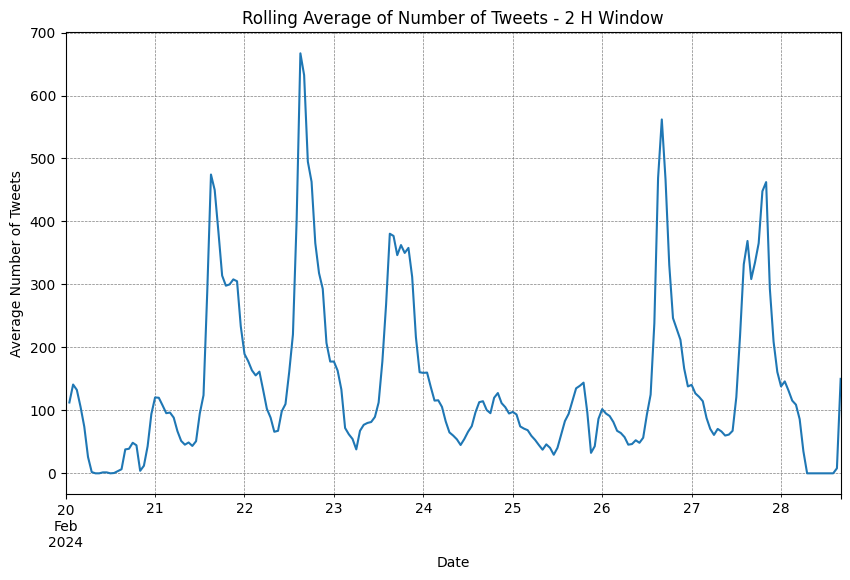

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure your datetime column is the index
if not isinstance(df.index, pd.DatetimeIndex):
    print("fixing")
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

# Editable variables
granularity = 'H'  # 'D' for daily, 'H' for hourly, etc.
rolling_window = 2  # Rolling window in terms of the granularity units

# Resample data according to the specified granularity
resampled_df = df.resample(granularity).size()  # Assuming you want to count the number of tweets

# Calculate the rolling average
rolling_avg = resampled_df.rolling(window=rolling_window).mean()

# Plotting
plt.figure(figsize=(10, 6))
rolling_avg.plot(title=f'Rolling Average of Number of Tweets - {rolling_window} {granularity} Window')
plt.ylabel('Average Number of Tweets')
plt.xlabel('Date')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

Bullish/Bearish Ratio (by Day)

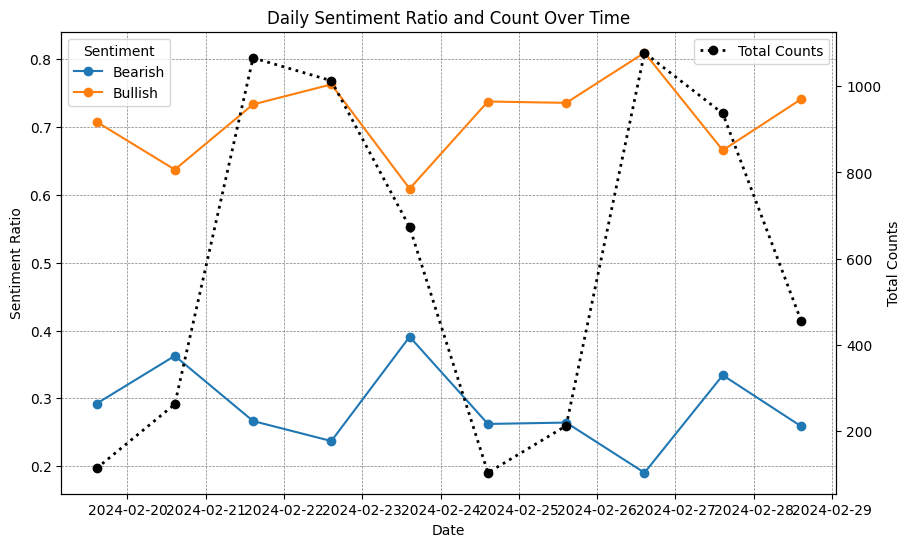

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

import ast

# Check if 'entities' column is stringified dictionaries and convert if necessary
if isinstance(df.iloc[0]['entities'], str):
    df['entities'] = df['entities'].apply(ast.literal_eval)

# Extracting 'bullishBearish' again to be safe
df['bullishBearish'] = df.apply(lambda row: row['entities']['sentiment'].get('basic', None) if 'sentiment' in row['entities'] and row['entities']['sentiment'] is not None else None, axis=1)
# Convert to 'category' dtype
df['bullishBearish'] = df['bullishBearish'].astype('category')

# Resample to daily sentiment ratio
daily_sentiment_ratio = df.resample('D', offset='14H30T')['bullishBearish'].value_counts(normalize=True).unstack(fill_value=0)

# Calculate daily counts
daily_sentiment_counts = df.resample('D', offset='14H30T')['bullishBearish'].count()

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the sentiment ratio with markers
for column in daily_sentiment_ratio.columns:
    ax1.plot(daily_sentiment_ratio.index, daily_sentiment_ratio[column], marker='o', linestyle='-', label=column)

ax1.set_ylabel('Sentiment Ratio')
ax1.set_xlabel('Date')
ax1.legend(title='Sentiment', loc='upper left')

# Add gridlines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Create a secondary y-axis for sentiment counts
ax2 = ax1.twinx()
ax2.plot(daily_sentiment_counts.index, daily_sentiment_counts, color='black', linestyle=':', linewidth=2, label='Total Counts', marker='o')

ax2.set_ylabel('Total Counts')
ax2.legend(loc='upper right')

plt.title('Daily Bullish/Bearish Ratio and Count Over Time')
plt.show()

Bullish/Bearish Indicator (Past Week)

In [ ]:
# !pip install plotly
# !pip install -U nbformat
# !pip show nbformat
# !pip install ipykernel

In [59]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# import matplotlib.dates as mdates
# from matplotlib.ticker import AutoMinorLocator

# import plotly.graph_objects as go

# # Assuming 'hourly_sentiments' is your DataFrame

# # Initialize a figure
# fig = go.Figure()

# # Generate a color map similar to 'coolwarm' in matplotlib
# colors = ['#3b4cc0', '#6889ff', '#9dbeff', '#999999', '#ff817b', '#e4554d', '#c02c38']  # Simplified version


# for i, column in enumerate(hourly_sentiments.columns):
#     fig.add_trace(go.Scatter(x=hourly_sentiments.index, y=hourly_sentiments[column],
#                             mode='lines', name=column,
#                             line=dict(color=colors[i % len(colors)])))  # Cycle through colors

# fig.update_layout(title='Hourly Sentiment Counts',
#                 xaxis=dict(title='Time', showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
#                 yaxis=dict(title='Sentiment COunts', showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
#                 legend_title='Sentiment',
#                 plot_bgcolor='white')

# fig.show()


# # Plot rates of change in sentiment counts

# import plotly.graph_objects as go

# # Assuming 'hourly_sentiments_derivative' is your DataFrame

# # Initialize a figure
# fig = go.Figure()

# # Generate a color map similar to 'coolwarm' in matplotlib
# colors = ['#3b4cc0', '#9dbeff', '#ffffff', '#ff817b', '#c02c38']  # Simplified version

# for i, column in enumerate(hourly_sentiments_derivative.columns):
#     fig.add_trace(go.Scatter(x=hourly_sentiments_derivative.index, y=hourly_sentiments_derivative[column],
#                             mode='lines', name=column,
#                             line=dict(color=colors[i % len(colors)])))  # Cycle through colors

# # Add grid lines manually if desired
# fig.update_layout(title='Hourly Rate of Change in Sentiment Counts',
#                 xaxis=dict(title='Time', showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
#                 yaxis=dict(title='Rate of Change', showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
#                 plot_bgcolor='white',
#                 legend_title='Sentiment')

# fig.show()





In [4]:
import plotly.graph_objects as go

red_to_green_scale = [
    '#ff0000',  # Red
    '#ff4000',  # Red-Orange
    '#ff8000',  # Orange
    '#ffbf00',  # Yellow-Orange
    '#ffff00',  # Yellow
    '#bfff00',  # Yellow-Green
    '#80ff00',  # Green
]

In [58]:
# Create a Plotly figure
fig = go.Figure()

# Using the red_to_green_scale for color
for i, column in enumerate(hourly_sentiments_derivative.columns):
    color = red_to_green_scale[i % len(red_to_green_scale)]
    
    fig.add_trace(go.Scatter(x=hourly_sentiments_derivative.index, y=hourly_sentiments_derivative[column],
                            mode='lines', name=column, line=dict(color=color)))

# Update layout with titles, axis labels, and grid lines
fig.update_layout(
    title='Sentiment Rate of Change Over Time',
    xaxis_title='Time',
    yaxis_title='Rate of Change',
    xaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    plot_bgcolor='white',
    legend_title='Sentiment',
    legend=dict(traceorder='normal', font=dict(family="sans-serif", size=12, color="black")),
    margin=dict(l=20, r=20, t=30, b=20)
)

# Show the figure

In [6]:
# Create a Plotly figure
fig = go.Figure()

# Using the red_to_green_scale for color
for i, column in enumerate(hourly_sentiments.columns):
    color = red_to_green_scale[i % len(red_to_green_scale)]
    
    fig.add_trace(go.Scatter(x=hourly_sentiments.index, y=hourly_sentiments[column],
                            mode='lines', name=column, line=dict(color=color)))

# Update layout with titles, axis labels, and grid lines
fig.update_layout(
    title='Sentiment Rate Over Time',
    xaxis_title='Time',
    yaxis_title='Rate of Change',
    xaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    plot_bgcolor='white',
    legend_title='Sentiment',
    legend=dict(traceorder='normal', font=dict(family="sans-serif", size=12, color="black")),
    margin=dict(l=20, r=20, t=30, b=20)
)

# Show the figure

Emotions over time (percentage)

In [60]:
import plotly.graph_objects as go

# Assuming 'hourly_sentiments' is your DataFrame

# Create a Plotly figure
fig = go.Figure()

# Add traces for each column in the DataFrame without specifying colors
for column in hourly_emotions.columns:
    fig.add_trace(go.Scatter(x=hourly_emotions.index, y=hourly_emotions[column],
                            mode='lines', name=column))

# Update layout with titles, axis labels, and grid lines
fig.update_layout(
    title='Emotion Rate',
    xaxis_title='Time',
    yaxis_title='Rate',
    xaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    plot_bgcolor='white',
    legend_title='Emotion',
    legend=dict(traceorder='normal', font=dict(family="sans-serif", size=12, color="black")),
    margin=dict(l=20, r=20, t=30, b=20)
)

# Show the figure
fig.show()


In [61]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add traces for each column in the DataFrame without specifying colors
for column in hourly_emotions_derivative.columns:
    fig.add_trace(go.Scatter(x=hourly_emotions_derivative.index, y=hourly_emotions_derivative[column],
                            mode='lines', name=column))

# Update layout with titles, axis labels, and grid lines
fig.update_layout(
    title='Emotion Derivative',
    xaxis_title='Time',
    yaxis_title='Rate',
    xaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    plot_bgcolor='white',
    legend_title='Emotion',
    legend=dict(traceorder='normal', font=dict(family="sans-serif", size=12, color="black")),
    margin=dict(l=20, r=20, t=30, b=20)
)

# Show the figure
fig.show()


Up/Down Prediction based on news (Last 24 hours of news) Vs. Actual Stock Price

In [ ]:
import matplotlib.pyplot as plt

prediction_ranges_dubug = [(-3, -2), (-2, -1), (-1, 0), (0, 1), (1, 2), (2, 3), (3, 4)]

# Assuming 'predictions' is your DataFrame with predictions and 'stock_data' is from yfinance
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Stock Price', color=color)
ax1.plot(stock_data.index, stock_data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Assuming the predictions DataFrame is indexed by the date and has a 'Prediction' column
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Prediction', color=color)
ax2.plot(predictions.index, predictions['Prediction'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to make sure the right y-label is not slightly clipped
plt.title('Stock Price and Predictions Overlay')
plt.show()


News Volume (Every 24 hours of news) From 2:30PM GMT

News Prediction Vs. Actual Stock Price

Word Cloud

In [ ]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import re

def extract_financial_keywords(tweet):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in word_tokenize(tweet) if word.isalnum() and word.lower() not in stop_words]
    tagged_words = nltk.pos_tag(words)
    keywords = [word for word, tag in tagged_words if tag in ['NN', 'VB', 'VBD', 'VBN']]
    return keywords

# Define timeframe
start_datetime = datetime(2024, 2, 5, 13, 00, tzinfo=pytz.utc)
end_datetime = datetime(2024, 2, 5, 14, 00, tzinfo=pytz.utc)
# Load and filter tweets
file_path = 'english_tweets.jsonl'
tweets = load_and_filter_tweets(file_path, start_datetime, end_datetime)

# Debug: 
st_search_term = "Tesla OR TSLA"
# Extract financial keywords for each tweet and accumulate the results
all_keywords = []
for tweet in tweets:
    cleaned_tweet = clean_tweet_content(tweet, st_search_term)
    keywords = extract_financial_keywords(cleaned_tweet)
    all_keywords.extend(keywords)

# Display or process the accumulated keywords
print(all_keywords)
a = Counter(all_keywords)
print(a.most_common())



In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(word_list):
    """Generate and display a word cloud from a list of words."""
    text = ' '.join(word_list)
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    
    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Assuming `all_keywords` is a list of all keywords extracted for a specific time frame
generate_word_cloud(all_keywords)


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_keyword_frequencies(keywords):
    """Plot a bar chart of keyword frequencies."""
    # Count the occurrences of each keyword
    counts = Counter(keywords)
    
    # Get the most common keywords and their counts
    common_keywords = counts.most_common(10)
    words, frequencies = zip(*common_keywords)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.title('Top Keywords Frequency')
    plt.show()

# Example usage with a list of keywords
plot_keyword_frequencies(all_keywords)